In [1]:
import sys
import jax
import os
import time
import pickle
import genjax
import bayes3d as b
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")
from viz import *
from utils import *
from mcs_utils import *
from PIL import Image
from io import BytesIO
import bayes3d.transforms_3d as t3d
from jax.debug import print as jprint
from tqdm import tqdm
from dataclasses import dataclass
from genjax.generative_functions.distributions import ExactDensity
import jax.tree_util as jtu
from genjax._src.core.transforms.incremental import NoChange, UnknownChange, Diff
console = genjax.pretty()
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Loading and preprocessing all data and renderer
# TODO TODO: CODE MAY CRASH IF NO OBJECTS DETECTED --> need to fix
SCALE = 0.2
cam_pose = CAM_POSE_CV2
inverse_cam_pose = jnp.linalg.inv(CAM_POSE_CV2)
observations = load_observations_npz('passive_physics_validation_object_permanence_0001_02')
preprocessed_data = preprocess_mcs_physics_scene(observations, MIN_DIST_THRESH=0.6, scale=SCALE)
(gt_images, gt_images_bg, gt_images_obj, intrinsics),(gt_images_orig, gt_images_bg_orig, gt_images_obj_orig, intrinsics_orig), registered_objects = preprocessed_data

# # Instead of running the code above, i will pickle import in the y_ref
# with open("obs.pkl", 'wb') as file:
#     pickle.dump(preprocessed_data, file)
# with open('obs.pkl', 'rb') as file:
#     (gt_images, gt_images_bg, gt_images_obj, intrinsics),(gt_images_orig, gt_images_bg_orig, gt_images_obj_orig, intrinsics_orig), registered_objects = pickle.load(file)


Extracting Meshes


 54%|█████▍    | 130/240 [00:07<00:02, 47.90it/s]

Adding review
Review passed, added to init queue
Adding new mesh for t = {} 132


 71%|███████▏  | 171/240 [00:43<01:08,  1.01it/s]

Adding review
Review failed


 74%|███████▍  | 178/240 [00:46<00:39,  1.55it/s]

Adding review
Review Stack not resolved, object may have left view, deleting review


100%|██████████| 240/240 [00:49<00:00,  4.84it/s]


Extracting downsampled data


In [3]:
b.setup_renderer(intrinsics)
for registered_obj in registered_objects:
    b.RENDERER.add_mesh(registered_obj['mesh'])
if len(registered_objects) == 0:
    registered_objects.append({'t_init' : 11,
                            'pose' : jnp.eye(4).at[:3,3].set([0,0,1e+5]),
                            'full_pose' : jnp.eye(4).at[:3,3].set([0,0,1e+5]),
                            't_full' : 11})
    b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/cube.obj"), scaling_factor = 0.1)
# video_from_rendered(gt_images, scale = int(1/SCALE), framerate=30)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 96, 1024)
Centering mesh with translation [-2.4998635e-03  5.0000250e-03  5.8114529e-07]


In [4]:
# model time!

def get_height_bounds(i, world_pose):
    # Half dimensions to get the corner points relative to the center
    rotation_matrix = world_pose[:3,:3]
    center = world_pose[:3,3]
    dimensions = b.RENDERER.model_box_dims[i]
    half_dims = dimensions / 2

    # Local corner points of the box in its local coordinate system
    local_corners = jnp.array([
        [-half_dims[0], -half_dims[1], -half_dims[2]],  # Lower rear left corner
        [ half_dims[0], -half_dims[1], -half_dims[2]],  # Lower rear right corner
        [-half_dims[0],  half_dims[1], -half_dims[2]],  # Lower front left corner
        [ half_dims[0],  half_dims[1], -half_dims[2]],  # Lower front right corner
        [-half_dims[0], -half_dims[1],  half_dims[2]],  # Upper rear left corner
        [ half_dims[0], -half_dims[1],  half_dims[2]],  # Upper rear right corner
        [-half_dims[0],  half_dims[1],  half_dims[2]],  # Upper front left corner
        [ half_dims[0],  half_dims[1],  half_dims[2]]   # Upper front right corner
    ])

    # Apply rotation to each corner point
    global_corners = jnp.stack([center + rotation_matrix @ corner for corner in local_corners])

    # Find the bottom-most point
    bottom_most_point_z = jnp.min(global_corners[:,2])
    top_most_point_z = jnp.max(global_corners[:,2])
    # distance from centre of bbox to bottom of bbox
    center_to_bottom_dist = center[2] - bottom_most_point_z
    return bottom_most_point_z,top_most_point_z, center_to_bottom_dist

def get_translation_direction(all_poses, t_full, t):
    direction = all_poses[t-1][:3,3] - all_poses[t_full][:3,3]
    direction = cam_pose[:3,:3] @ direction
    direction_xy = direction.at[2].set(0)

    normalized_direction_xy = jax.lax.cond(jnp.equal(jnp.linalg.norm(direction_xy), 0),
                                         lambda: direction_xy,
                                         lambda: direction_xy/jnp.linalg.norm(direction_xy))
    return normalized_direction_xy


# This model has to be recompiled for different # objects for now this is okay
@genjax.gen
def physics_stepper(all_poses, t, t_full, i, friction, gravity):
    # TODO: SAMPLING FRICTION SCHEME --> can be of a hmm style

    #################################################################
    # First let us consider timestep t-1
    #################################################################
    # Step 2: find world pose
    pose_prev = all_poses[t-1]
    pose_prev_world = cam_pose @ pose_prev

    # Step 3: check if we are already on the floor
    bottom_z, top_z, center_to_bottom = get_height_bounds(i, pose_prev_world)
    # within 20% of the object's height in world frame
    already_on_floor = jnp.less_equal(bottom_z,0.2 * (top_z - bottom_z))
    
    # Step 1: Find world velocity
    vel_pose_camera = jnp.linalg.solve(all_poses[t-2], all_poses[t-1])
    pre_vel_xyz_world = cam_pose[:3,:3] @ vel_pose_camera[:3,3]
    mag_xy = jnp.linalg.norm(pre_vel_xyz_world[:2])
    
    mag_xy_friction = mag_xy - friction * mag_xy

    mag_xy_friction = jax.lax.cond(
        jnp.less_equal(jnp.abs(mag_xy_friction),3e-2),
        lambda:0.0,
        lambda:mag_xy_friction)
    
    mag_xy, gravity = jax.lax.cond(already_on_floor,lambda:(mag_xy_friction,gravity),lambda:(mag_xy, gravity))

    dir_xy_world = get_translation_direction(all_poses, t_full, t)

    # Step 7: Determine mag and gravity

    vel_xyz_world = mag_xy * dir_xy_world
    # Step 6: apply z axis change
    vel_xyz_world = vel_xyz_world.at[2].set(pre_vel_xyz_world[2] - gravity * 1./20)

    # Step 5: find peturbed velocity (equal to original norm) with random rotation
    perturbed_rot_pose = GaussianVMFPoseUntraced()(jnp.eye(4), *(1e-20, 1000.0))  @ "perturb"

    vel_xyz_world_perturbed = perturbed_rot_pose[:3,:3] @ vel_xyz_world # without friction

    vel_xyz_camera = inverse_cam_pose[:3,:3] @ vel_xyz_world_perturbed

    # Step 8: Get velocity update in camera frame
    vel = pose_prev.at[:3,3].set(vel_xyz_camera)

    # Step 9: Identify next pose
    next_pose = pose_prev.at[:3,3].set(pose_prev[:3,3] + vel[:3,3]) # trans only, no rot

    # Step 10: Ensure new bottom of object is above floor --> ground collision
    next_pose_world = cam_pose @ next_pose
    bottom_z,_,center_to_bottom = get_height_bounds(i, next_pose_world)
    next_pose = jax.lax.cond(
        jnp.less_equal(bottom_z,0),
        lambda:inverse_cam_pose @ next_pose_world.at[2,3].set(center_to_bottom),
        lambda:next_pose
    )

    return next_pose

def threedp3_likelihood_arijit(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = (distances < variance/2) / variance
    average_probability = 1 * probabilities_per_pixel.mean()
    return average_probability

def outlier_gaussian(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = jax.scipy.stats.norm.pdf(
        distances,
        loc=0.0, 
        scale=variance
    )
    average_probability = probabilities_per_pixel.mean()
    return average_probability

@dataclass
class ImageLikelihoodArijit(ExactDensity):
    def sample(self, key, img, variance, outlier_prob):
        return img

    def logpdf(self, observed_image, latent_image, variance, outlier_prob):
        return threedp3_likelihood_arijit(
            observed_image, latent_image, variance, outlier_prob,
        )
    
@dataclass
class GaussianVMFPoseUntraced(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return 0

@genjax.gen
def mcs_model(prev_state, t_inits, t_fulls, init_poses, full_poses, pose_update_params, gravity, variance, outlier_prob):
    """
    Single Object Model HMM
    """

    (_, _, poses, all_poses, friction, t) = prev_state

    # jprint("t = {}, f = {}",t, friction)

    num_objects = poses.shape[0]
    
    # for each object
    for i in range(num_objects):        
        physics_prob = jnp.asarray(jax.lax.cond(jnp.greater_equal(t,t_fulls[i]+2),lambda:1,lambda:0), dtype=int)
        physics_pose = physics_stepper(all_poses[:,i,...], t, t_fulls[i], i, friction, gravity) @ f"physics_{i}"
        final_pose = jax.lax.cond(physics_prob, lambda:physics_pose, lambda:poses[i])
        updated_pose = b.gaussian_vmf_pose(final_pose, *pose_update_params)  @ f"pose_{i}"
        poses = poses.at[i].set(updated_pose)
        
        poses = poses.at[i].set(jax.lax.cond(
            jnp.equal(t_inits[i],t), # init pose at the correct time step
            lambda:init_poses[i], 
            lambda:poses[i]))
        
        poses = poses.at[i].set(jax.lax.cond(
            jnp.equal(t_fulls[i],t), # full pose at the correct time step
            lambda:full_poses[i], 
            lambda:poses[i]))

    all_poses = all_poses.at[t].set(poses)
    rendered_image_obj = b.RENDERER.render(
        poses, jnp.arange(num_objects))[...,:3]

    # NOTE: gt_images_bg is a global variable here as it consumes too much memory for the trace
    rendered_image = splice_image(rendered_image_obj, gt_images_bg[t])

    sampled_image = ImageLikelihoodArijit()(rendered_image, variance, outlier_prob) @ "depth"
    # sampled_image = b.old_image_likelihood(rendered_image, 0.1, 0.001,1000,None) @ "depth"

    return (rendered_image, rendered_image_obj, poses, all_poses, friction, t+1)

In [5]:
def pose_update_v5(key, trace_, pose_grid, enumerator):
    num_splits = (pose_grid.shape[0] // 400) + 1
    all_weights = jnp.array([])
    for split_pose_grid in jnp.array_split(pose_grid, num_splits):
        weights = enumerator.enumerate_choices_get_scores(trace_, key, split_pose_grid)
        all_weights = jnp.hstack([all_weights, weights])
    sampled_idx = all_weights.argmax() # jax.random.categorical(key, weights)
    # jprint("weights = {}",weights)
    # jprint("idx chosen = {}",sampled_idx)
    return *enumerator.update_choices_with_weight(
        trace_, key,
        pose_grid[sampled_idx]
    ), pose_grid[sampled_idx]


pose_update_v5_jit = jax.jit(pose_update_v5, static_argnames=("enumerator",))


def c2f_pose_update_v5(key, trace_, reference, gridding_schedule, enumerator, obj_id):
    # for each object (TODO: gibbs sampling)
    for i in range(len(gridding_schedule)):
        updated_grid = jnp.einsum("ij,ajk->aik", reference, gridding_schedule[i])
        # Time to check valid poses that dont intersect with the floor
        valid = jnp.logical_not(are_bboxes_intersecting_many_jit(
                            (100,100,20),
                            b.RENDERER.model_box_dims[obj_id],
                            jnp.eye(4).at[:3,3].set([0,0,-10]),
                            jnp.einsum("ij,ajk->aik",cam_pose,updated_grid)
                            ))
        # if pose is not valid, use the reference pose
        valid_grid = jnp.where(valid[:,None,None], updated_grid, reference[None,...])
        weight, trace_, reference = pose_update_v5_jit(key, trace_, valid_grid, enumerator)
        # jprint("ref position is {}", reference[:3,3])

    return weight, trace_

c2f_pose_update_v5_vmap_jit = jax.jit(jax.vmap(c2f_pose_update_v5, in_axes=(0,0,None,None,None)),
                                    static_argnames=("enumerator", "obj_id"))

c2f_pose_update_v5_jit = jax.jit(c2f_pose_update_v5,static_argnames=("enumerator", "obj_id"))

def make_new_keys(key, N_keys):
    key, other_key = jax.random.split(key)
    new_keys = jax.random.split(other_key, N_keys)
    return key, new_keys

def update_choice_map_no_unfold(gt_depths, constant_choices, t):
    constant_choices['depth'] = gt_depths[t]
    return genjax.choice_map(
                constant_choices
            )


def argdiffs_modelv7(trace):
    """
    Argdiffs specific to mcs_single_obejct model with no unfold
    """
    args = trace.get_args()
    argdiffs = (
        jtu.tree_map(lambda v: Diff(v, UnknownChange), args[0]),
        *jtu.tree_map(lambda v: Diff(v, NoChange), args[1:]),
    )
    return argdiffs



def proposal_choice_map_no_unfold(addresses, args, chm_args):
    addr = addresses[0] # custom defined
    return genjax.choice_map({
                        addr: args[0]
            })

In [6]:
def inference_approach_G2(model, gt, gridding_schedules, model_args, init_state, key, friction_params, constant_choices, T, addr, n_particles):
    """
    Sequential Importance Sampling on the non-unfolded HMM model
    with 3D pose enumeration proposal

    WITH JUST ONE PARTICLE
    """
    
    num_objects = init_state[2].shape[0]

    def get_next_state(particle):
        return (None,None,*particle.get_retval()[2:])
    get_next_state_vmap = jax.vmap(get_next_state, in_axes = (0,))

    # sample friction
    key, friction_keys = make_new_keys(key, n_particles)
    # frictions = jax.vmap(genjax.normal.sample, in_axes = (0,None,None))(friction_keys,*friction_params)
    frictions = jnp.linspace(-0.03,0.05,n_particles)
    # broadcast init_state to number of particles
    init_states = jax.vmap(lambda x:(*init_state[:4], x, *init_state[4:]), in_axes=(0,))(frictions)

    # define functions for SIS/SMC
    init_fn = jax.jit(jax.vmap(model.importance, in_axes=(0,None,0)))
    update_fn = jax.jit(model.update)
    proposal_fn = c2f_pose_update_v5_jit

    def smc_body(carry, t):
        # get new keys
        print("jit compiling")
        # initialize particle based on last time step
        jprint("t = {}",t)
        
        key, log_weights, states,  = carry
        key, importance_keys = make_new_keys(key, n_particles)
        key, resample_key = jax.random.split(key)
        key, proposal_key = jax.random.split(key)

        variance = jax.lax.cond(
            jnp.less_equal(t, model_args[1][0] + 2),
            lambda: 5 * model_args[6],
            lambda: model_args[6]
        )

        modified_model_args = (*model_args[:6], variance, *model_args[7:])

        full_args = jax.vmap(lambda x,y:(x, *y), in_axes=(0,None))(states, modified_model_args)

        importance_log_weights, particles = init_fn(importance_keys, update_choice_map_no_unfold(gt,constant_choices, t), full_args)
        # # Resampling at every time step
        # sampled_indices = jax.random.categorical(resample_key, log_weights, shape=(n_particles,))
        # particles = jtu.tree_map(lambda v: v[sampled_indices], particles)


        # propose good poses based on proposal
        def proposer(carry, p):
            key, idx = carry
            proposal_log_weight = 0
            # argdiff and enumerator
            argdiffs = argdiffs_modelv7(p)
            enumerators = [b.make_enumerator([(addr + f'_{i}')], 
                                        chm_builder = proposal_choice_map_no_unfold,
                                        argdiff_f=lambda x: argdiffs
                                        ) for i in range(num_objects)] 
            for obj_id in range(num_objects):
                key, new_key = jax.random.split(key)
                w, p = proposal_fn(new_key, p, states[2][idx][obj_id], gridding_schedules[obj_id], enumerators[obj_id], obj_id)
                proposal_log_weight += w
            return (new_key, idx + 1), (proposal_log_weight, p)
        _, (proposal_log_weights, proposed_particles) = jax.lax.scan(proposer, (proposal_key, 0), particles)

        # get weights of particles
        new_log_weight = log_weights + importance_log_weights + proposal_log_weights
        next_states = get_next_state_vmap(proposed_particles)

        return (key, new_log_weight, next_states), proposed_particles

    (_, final_log_weight, _), particles = jax.lax.scan(
        smc_body, (key, jnp.zeros(n_particles), init_states), jnp.arange(0, T))
    rendered = particles.get_retval()[0]
    rendered_obj = particles.get_retval()[1]
    inferred_poses = particles.get_retval()[2]
    print("SCAN finished")
    return final_log_weight, rendered, rendered_obj, inferred_poses, particles

In [7]:
# enumeration grid
# TODO: ADAPTIVE GRID SIZING
# grid_widths = [1, 0.2,0.04,0.008,0.002,0.0004]
# # grid_widths = [0.5, 0.1,0.02]
# grid_nums = [(7,7,7),(7,7,7),(7,7,7), (7,7,7), (7,7,7), (7,7,7)]
# gridding_schedule_trans = make_schedule_translation_3d(grid_widths, grid_nums)
# gridding_schedule_rot = [b.utils.make_rotation_grid_enumeration(10, 15, -jnp.pi/12, jnp.pi/12, jnp.pi/12)]
# # gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], gridding_schedule_trans[2], gridding_schedule_rot[0]]
# gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], 
#                      gridding_schedule_trans[2], gridding_schedule_trans[3],
#                      gridding_schedule_trans[4], gridding_schedule_trans[5]]


gridding_schedules = []
for box_dims in b.RENDERER.model_box_dims:
    c2fm1 = 2
    c2f0 = 1
    c2f1 = 0.7 * c2f0
    c2f2 = 0.7 * c2f1
    c2f3 = 0.2 * c2f2
    c2f4 = 0.2 * c2f3
    c2f5 = 0.2 * c2f4
    c2f6 = 0.2 * c2f5

    c2fs = [c2fm1, c2f0,c2f1,c2f2,c2f3,c2f4,c2f5,c2f6]

    x,y,z = box_dims
    grid_widths = [[c2f*x, c2f*y, c2f*z] for c2f in c2fs]

    grid_nums = [(7,7,7),(7,7,7),(7,7,7),(7,7,7), (7,7,7), (7,7,7), (7,7,7), (7,7,7)]
    gridding_schedule_trans = make_schedule_translation_3d_variable_grid(grid_widths, grid_nums)
    gridding_schedules.append(gridding_schedule_trans)

# Setup for inference
T = gt_images.shape[0]
num_registered_objects = len(registered_objects)
friction_params = (0.01,0.005)
INIT_STATE = (
        None,
        None,
        jnp.tile(jnp.eye(4).at[2,3].set(1e+5)[None,...],(num_registered_objects,1,1)),
        jnp.zeros((T,num_registered_objects,4,4)),
        0
)
MODEL_ARGS = (
     jnp.array([r['t_init'] for r in registered_objects]),
     jnp.array([r['t_full'] for r in registered_objects]),
     jnp.array([r['pose'] for r in registered_objects]),
     jnp.array([r['full_pose'] for r in registered_objects]),
     jnp.array([5e-0, 5e-1]),
     9.81/4,
     0.1,
     None
)
CONSTANT_CHOICES = {}

key = jax.random.PRNGKey(np.random.randint(0,2332423432))

model = mcs_model

start = time.time()
lw, rendered, rendered_obj, inferred_poses, trace = inference_approach_G2(model, gt_images, 
    gridding_schedules, MODEL_ARGS, INIT_STATE, key, friction_params, CONSTANT_CHOICES, T, "pose", 10)
print ("FPS:", rendered.shape[0] / (time.time() - start))

jit compiling
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9
t = 10
t = 11
t = 12
t = 13
t = 14
t = 15
t = 16
t = 17
t = 18
t = 19
t = 20
t = 21
t = 22
t = 23
t = 24
t = 25
t = 26
t = 27
t = 28
t = 29
t = 30
t = 31
t = 32
t = 33
t = 34
t = 35
t = 36
t = 37
t = 38
t = 39
t = 40
t = 41
t = 42
t = 43
t = 44
t = 45
t = 46
t = 47
t = 48
t = 49
t = 50
t = 51
t = 52
t = 53
t = 54
t = 55
t = 56
t = 57
t = 58
t = 59
t = 60
t = 61
t = 62
t = 63
t = 64
t = 65
t = 66
t = 67
t = 68
t = 69
t = 70
t = 71
t = 72
t = 73
t = 74
t = 75
t = 76
t = 77
t = 78
t = 79
t = 80
t = 81
t = 82
t = 83
t = 84
t = 85
t = 86
t = 87
t = 88
t = 89
t = 90
t = 91
t = 92
t = 93
t = 94
t = 95
t = 96
t = 97
t = 98
t = 99
t = 100
t = 101
t = 102
t = 103
t = 104
t = 105
t = 106
t = 107
t = 108
t = 109
t = 110
t = 111
t = 112
t = 113
t = 114
t = 115
t = 116
t = 117
t = 118
t = 119
t = 120
t = 121
t = 122
t = 123
t = 124
t = 125
t = 126
t = 127
t = 128
t = 129
t = 130
t = 131
t = 132
t = 133
t = 134
t = 135
t = 136


In [8]:
w = trace.project(genjax.select("depth"))
start = registered_objects[0]['t_full']+3
gap = w.max()-w.min()

rendering_ll_images = []

fig, ax = plt.subplots()  # Using subplots to directly access the figure object
lines = []
for p_id in range(w.shape[1]):
    line = ax.plot(np.arange(0,1),w[:,p_id][0:1], label = f"Particle {p_id+1}")[0]
    lines.append(line)
ax.set_xlim([start,T])
ax.set_ylim([9.7,10.02])
# ax.set_ylim([w.min()-0.1*gap,w.max()+0.1*gap])
ax.set_xlabel("Time")
ax.set_ylabel("Log Likelihood")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.subplots_adjust(right=0.75)
fig.canvas.draw()
rendering_ll_img = b.pil_image_from_matplotlib(fig)

for _ in tqdm(range(0,start)):
    rendering_ll_images.append(rendering_ll_img.copy().resize((600,400)))

for t in tqdm(range(start,T)):
    for p_id in range(w.shape[1]):
        lines[p_id].set_data(np.arange(start,t+1),w[:,p_id][start:t+1])
    fig.canvas.draw()
    rendering_ll_img = b.pil_image_from_matplotlib(fig)
    rendering_ll_images.append(rendering_ll_img.resize((600,400)))
    plt.close()

w = trace.project(genjax.select("pose_0"))
start = registered_objects[0]['t_full']+3
gap = w.max()-w.min()

physics_ll_images = []

fig, ax = plt.subplots()  # Using subplots to directly access the figure object
lines = []
for p_id in range(w.shape[1]):
    line = ax.plot(np.arange(start,start+1),w[:,p_id][start:start+1], label = f"Particle {p_id+1}")[0]
    lines.append(line)
ax.set_xlim([start,T]) 
ax.set_ylim([-10.12,-10.095])
# ax.set_ylim([w.min()-0.1*gap,w.max()+0.1*gap])
ax.set_xlabel("Time")
ax.set_ylabel("Log Likelihood")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.subplots_adjust(right=0.75)
fig.canvas.draw()
physics_ll_img = b.pil_image_from_matplotlib(fig)

for _ in tqdm(range(0,start)):
    physics_ll_images.append(physics_ll_img.copy().resize((600,400)))

for t in tqdm(range(start,T)):
    for p_id in range(w.shape[1]):
        lines[p_id].set_data(np.arange(start,t+1),w[:,p_id][start:t+1])
    fig.canvas.draw()
    physics_ll_img = b.pil_image_from_matplotlib(fig)
    physics_ll_images.append(physics_ll_img.resize((600,400)))
    plt.close()

p_images = get_particle_images(intrinsics_orig, inferred_poses, T = T)
blended_images = [b.overlay_image(p_images[i],b.get_depth_image(gt_images_orig[i][...,2])) for i in range(len(p_images))]
images = []
for t in tqdm(range(T)):
    images.append(b.scale_image(b.multi_panel([
                b.get_depth_image(gt_images_orig[t,...,2]),
                # b.scale_image(b.get_depth_image(rendered[t,particle_id,...,2]),scale),
                blended_images[t],
                physics_ll_images[t],
                rendering_ll_images[t]
                # b.scale_image(b.get_depth_image(rendered_obj[t,particle_id,...,2]),3)
                ],labels = ['gt/observed', 'particles',
                            "physics likelihood", "rendering likelihood"]), 0.4))
display_video(images, framerate=30)

100%|██████████| 104/104 [00:08<00:00, 11.62it/s]


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x5641efaa2fe0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


100%|██████████| 240/240 [00:10<00:00, 22.56it/s]


<IPython.core.display.HTML object>

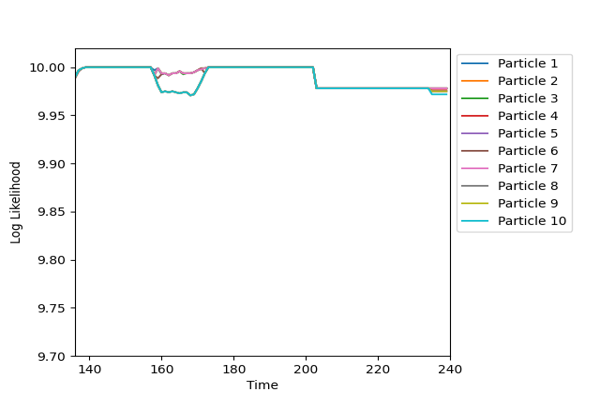

In [9]:
rendering_ll_images[-1]

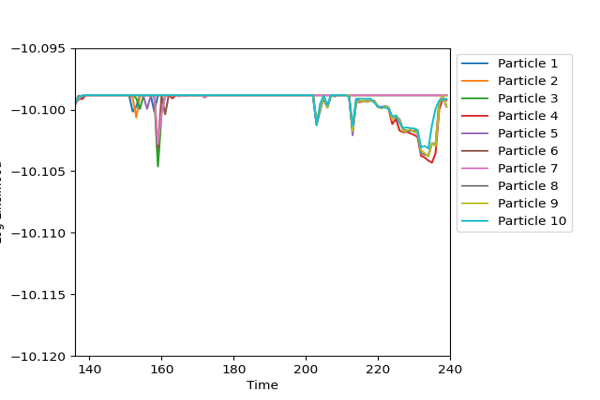

In [10]:
physics_ll_images[-1]

In [12]:
trace.score.shape

(240, 10)

In [ ]:
registered_objects

In [ ]:
all_poses = trace.get_retval()[2][:,:,0,...]
all_poses.shape

In [ ]:
def get_next_state(particle):
    return (None,None,*particle.get_retval()[2:])
get_next_state_vmap = jax.vmap(get_next_state, in_axes = (0,))
init_fn = jax.jit(jax.vmap(model.importance, in_axes=(0,None,0)))

particles = jtu.tree_map(lambda v: v[141], trace)
next_states = get_next_state_vmap(particles)
full_args = jax.vmap(lambda x,y:(x, *y), in_axes=(0,None))(next_states, MODEL_ARGS)
key, imp_keys = make_new_keys(key, 10)
_, particles = init_fn(imp_keys, update_choice_map_no_unfold(gt_images,{}, 142), full_args)


In [ ]:
jnp.linalg.norm((cam_pose @ all_poses[104,7,...])[:3,3] - (cam_pose @ all_poses[103,7,...])[:3,3])

In [ ]:
w = trace.project(genjax.select(("physics_0", "perturb")))
w.max() - w.min()

In [13]:
w = trace.project(genjax.select(("depth")))
# w.max() - w.min()
w[210]


Array([9.978126, 9.978126, 9.978126, 9.978126, 9.978126, 9.978126,
       9.978126, 9.978126, 9.978126, 9.978126], dtype=float32)

In [ ]:
w = trace.project(genjax.select(("pose_0")))
# w.max() - w.min()
w[142]

In [ ]:
# all_poses = trace.get_retval()[2]
display(cam_pose @ all_poses[123,0,...])
display(cam_pose @ all_poses[132,0,...])
blended_images[132]

In [ ]:
b.RENDERER.model_box_dims

In [ ]:
all_poses[131,0,...] - all_poses[123,0,...]

In [ ]:
registered_objects

In [ ]:
tt = 148
display(cam_pose @ all_poses[tt,0,...])
display(cam_pose @ all_poses[tt-1,0,...])
display(cam_pose @ all_poses[tt,0,...] - cam_pose @ all_poses[tt-1,0,...])
# trace.args[7][tt,0]

In [ ]:
cam_pose @ physics_stepper_debug(all_poses[:,0,...], 148, 135, 0, -0.03, 9.81/4)

In [ ]:
b.scale_image(b.get_depth_image(rendered_obj[136,0,...,2]),4)

In [ ]:
cam_pose @ registered_objects[0]['pose']

In [ ]:
propp = registered_objects[0]['full_pose'] @ gridding_schedule[0][172]
ggg = b.RENDERER.render(propp[None,...], jnp.array([0]))[...,:3]
fff = splice_image(ggg, gt_images_bg[142])
b.scale_image(b.get_depth_image(fff[...,2]),8)

In [ ]:
ImageLikelihoodArijit().logpdf(gt_images[142,...],fff[...],0.1,None)

In [ ]:
ImageLikelihoodArijit().logpdf(gt_images[142,...],gt_images_bg[142,...],0.1,None)


In [ ]:
outlier_gaussian(gt_images[142,...],gt_images_bg[142,...],0.01,None)

In [ ]:
gridding_schedule[0][172,:3,3]

In [ ]:
gridding_schedule[0][172]

In [ ]:
propp = registered_objects[0]['full_pose'] @ gridding_schedule[0][172]
cam_pose @ propp